In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *

np.random.seed(123)

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [10]:
# define transform function to constrain parameter values
def transform(params):
    
    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = params
    
    # take exp of strictly positive parameters
    mu_max = jnp.exp2(mu_max) 
    pref = jnp.exp2(pref)*7.
    Sigma_inv = jnp.exp2(Sigma_inv)/10.
    K_inv = jnp.exp2(K_inv)/10.
    delta = jnp.exp2(delta)/10.
    gamma = gamma/10.
    
    return jnp.array([mu_max, pref, Sigma_inv, K_inv, delta, gamma])

# ode 
def system(x, t, params): 

    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = transform(params)
    
    # unpack variables
    od, pH = x 
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (jnp.exp2(-Sigma_inv * (pH - pref)**2.) - delta) 
    dpH = (gamma * od) * (pH * (1. - pH / 14.))
    # dpH = (gamma * dod) * (pH * (1. - pH / 14.))
    
    return jnp.array([dod, dpH])  

# define prior mean of untransformed variables 
prior_mean = np.array([0., 0., 0., 0., 0., 0.])

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [11]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [12]:
df.describe()

,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,8.823529,6.284827,0.103395,0.024959,0.015209,0.018839,0.027583,0.016583,0.021769,0.002393,0.090695,0.079882,0.083556,0.097024
std,7.938535,1.033571,0.653701,0.278782,0.150054,0.180187,0.222743,0.208608,0.201716,0.009162,0.530186,0.463441,0.473807,0.582427
min,0.000000,4.976477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.152622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,6.168138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,7.337288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,8.150575,5.147123,4.072533,2.927829,2.700796,3.934214,3.976187,3.789218,0.075608,4.856178,4.326752,4.344400,5.313583


In [13]:
all_species = df.columns.values[3:]
all_species

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD'],
      dtype=object)

In [14]:
sp = all_species[7][:-3]
sp

'DF'

In [15]:
df_species = pd.concat([df_exp[['Treatments', 'Time', 'pH', sp+'_OD']] 
                   for exp_name, df_exp in df.groupby("Treatments") if sp in exp_name])
df_species

,Treatments,Time,pH,DF_OD
756,DF_pH4_0,0,5.003232,0.010000
757,DF_pH4_0,3,5.016297,0.010000
758,DF_pH4_0,6,5.046015,0.010000
759,DF_pH4_0,9,5.027032,0.010000
760,DF_pH4_0,12,5.018455,0.010000
...,...,...,...,...
859,DF_pH9_2,3,7.599856,0.029343
860,DF_pH9_2,6,7.548351,0.048898
861,DF_pH9_2,9,7.751730,0.031728
862,DF_pH9_2,12,7.730361,0.031251


## Specify system state variables 

In [16]:
# names of species
species = [sp+'_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [17]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
            transform = transform,
            dataframe = df_species, 
            sys_vars = species, 
            prior_mean = prior_mean,
               alpha=10.)

## Fit the parameter posterior

In [18]:
# fit to data 
t0 = time.time()
ode_model.fit_posterior_EM()

print("Elapsed time {:.2f}s".format(time.time()-t0))

Trial 1
Loss: 70590.758
Loss: 17326.176
Loss: 2917.805
Loss: 598.525
Loss: 465.918
Loss: 349.547
Loss: 342.813
Loss: 340.264
Loss: 339.406
Loss: 331.513
Loss: 318.209
Loss: 317.613
Loss: 312.124
Loss: 303.149
Loss: 303.045
Loss: 299.253
Loss: 294.331
Loss: 294.231
Loss: 293.343
Loss: 292.248
Loss: 292.239
Loss: 292.164
Loss: 292.123
Trial 2
Loss: 77523.367
Loss: 15796.153
Loss: 464.077
Loss: 311.883
Loss: 310.796
Loss: 301.594
Loss: 301.405
Loss: 299.616
Loss: 296.509
Loss: 292.829
Loss: 292.754
Loss: 292.613
Loss: 292.374
Loss: 292.131
Loss: 292.130
Loss: 292.129
Loss: 292.128
Loss: 292.127
Loss: 292.124
Loss: 292.122
Loss: 292.121
Trial 3
Loss: 48848.891
Loss: 7209.071
Loss: 2923.505
Loss: 595.837
Loss: 466.660
Loss: 450.571
Loss: 421.042
Loss: 373.788
Loss: 358.691
Loss: 356.325
Loss: 354.905
Loss: 342.374
Loss: 341.822
Loss: 336.573
Loss: 327.118
Loss: 311.905
Loss: 311.472
Loss: 307.444
Loss: 300.720
Loss: 300.656
Loss: 298.216
Loss: 294.566
Loss: 294.518
Loss: 294.068
Loss: 293.2

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 219.11it/s]


Updating posterior...
Epoch 1, NEG ELBO: 110.707
Epoch 2, NEG ELBO: 113.494
Epoch 3, NEG ELBO: 110.637
Epoch 4, NEG ELBO: 110.058
Epoch 5, NEG ELBO: 111.000
Epoch 6, NEG ELBO: 109.392
Epoch 7, NEG ELBO: 111.488
Epoch 8, NEG ELBO: 109.192
Epoch 9, NEG ELBO: 110.294
Epoch 10, NEG ELBO: 108.806
Epoch 11, NEG ELBO: 108.454, Slope: -0.003
Epoch 12, NEG ELBO: 110.763, Slope: -0.001
Epoch 13, NEG ELBO: 108.003, Slope: -0.002
Epoch 14, NEG ELBO: 108.449, Slope: -0.002
Epoch 15, NEG ELBO: 108.049, Slope: -0.002
Epoch 16, NEG ELBO: 111.122, Slope: -0.001
Epoch 17, NEG ELBO: 108.479, Slope: -0.000
Epoch 18, NEG ELBO: 108.237, Slope: -0.001
Epoch 19, NEG ELBO: 107.368, Slope: -0.001
Epoch 20, NEG ELBO: 106.570, Slope: -0.002
Epoch 21, NEG ELBO: 106.984, Slope: -0.003
Epoch 22, NEG ELBO: 106.680, Slope: -0.002
Epoch 23, NEG ELBO: 107.117, Slope: -0.003
Epoch 24, NEG ELBO: 106.678, Slope: -0.003
Epoch 25, NEG ELBO: 107.380, Slope: -0.003
Epoch 26, NEG ELBO: 106.813, Slope: -0.001
Epoch 27, NEG ELBO:

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.86it/s]


Log evidence: 199.889 +/- 0.000
Updating hyperparameters...


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 233.67it/s]


Updating posterior...
Epoch 1, NEG ELBO: 105.885
Epoch 2, NEG ELBO: 115.397
Epoch 3, NEG ELBO: 106.148
Epoch 4, NEG ELBO: 107.246
Epoch 5, NEG ELBO: 105.762
Epoch 6, NEG ELBO: 106.259
Epoch 7, NEG ELBO: 107.911
Epoch 8, NEG ELBO: 106.015
Epoch 9, NEG ELBO: 105.866
Epoch 10, NEG ELBO: 105.074
Epoch 11, NEG ELBO: 106.193, Slope: -0.005
Epoch 12, NEG ELBO: 105.432, Slope: -0.001
Epoch 13, NEG ELBO: 106.409, Slope: -0.001
Epoch 14, NEG ELBO: 105.732, Slope: -0.001
Epoch 15, NEG ELBO: 104.848, Slope: -0.001
Epoch 16, NEG ELBO: 106.188, Slope: -0.001
decrease lr to 9.000e-04
Epoch 17, NEG ELBO: 107.547, Slope: 0.001
decrease lr to 8.100e-04
Epoch 18, NEG ELBO: 104.356, Slope: 0.000
decrease lr to 7.290e-04
Epoch 19, NEG ELBO: 106.191, Slope: 0.000
Epoch 20, NEG ELBO: 105.323, Slope: -0.000
Epoch 21, NEG ELBO: 105.623, Slope: -0.000
Epoch 22, NEG ELBO: 104.260, Slope: -0.001
Epoch 23, NEG ELBO: 105.704, Slope: -0.001
Epoch 24, NEG ELBO: 105.102, Slope: -0.001
Epoch 25, NEG ELBO: 106.131, Slop

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.44it/s]


Log evidence: 205.259 +/- 0.000
Updating hyperparameters...


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 243.37it/s]


Updating posterior...
Epoch 1, NEG ELBO: 105.065
Epoch 2, NEG ELBO: 105.603
Epoch 3, NEG ELBO: 104.295
Epoch 4, NEG ELBO: 103.573
Epoch 5, NEG ELBO: 110.851
Epoch 6, NEG ELBO: 104.715
Epoch 7, NEG ELBO: 106.674
Epoch 8, NEG ELBO: 104.826
Epoch 9, NEG ELBO: 105.529
Epoch 10, NEG ELBO: 104.145
Epoch 11, NEG ELBO: 105.432, Slope: -0.000
Epoch 12, NEG ELBO: 103.956, Slope: -0.001
Epoch 13, NEG ELBO: 107.651, Slope: -0.001
Epoch 14, NEG ELBO: 103.708, Slope: -0.003
Epoch 15, NEG ELBO: 103.726, Slope: -0.001
Epoch 16, NEG ELBO: 104.906, Slope: -0.001
decrease lr to 9.000e-04
Epoch 17, NEG ELBO: 105.815, Slope: 0.000
decrease lr to 8.100e-04
Epoch 18, NEG ELBO: 105.170, Slope: 0.000
decrease lr to 7.290e-04
Epoch 19, NEG ELBO: 104.376, Slope: 0.000
Epoch 20, NEG ELBO: 104.350, Slope: -0.001
Epoch 21, NEG ELBO: 103.675, Slope: -0.001
Epoch 22, NEG ELBO: 103.281, Slope: -0.002
Epoch 23, NEG ELBO: 104.861, Slope: -0.000
decrease lr to 6.561e-04
Epoch 24, NEG ELBO: 107.217, Slope: 0.001
decrease 

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 55.47it/s]


Log evidence: 208.176 +/- 0.000
Updating hyperparameters...


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 245.91it/s]


Updating posterior...
Epoch 1, NEG ELBO: 104.531
Epoch 2, NEG ELBO: 106.304
Epoch 3, NEG ELBO: 103.200
Epoch 4, NEG ELBO: 103.374
Epoch 5, NEG ELBO: 105.522
Epoch 6, NEG ELBO: 103.527
Epoch 7, NEG ELBO: 103.963
Epoch 8, NEG ELBO: 103.499
Epoch 9, NEG ELBO: 103.227
Epoch 10, NEG ELBO: 104.664
decrease lr to 9.000e-04
Epoch 11, NEG ELBO: 106.392, Slope: 0.000
decrease lr to 8.100e-04
Epoch 12, NEG ELBO: 103.333, Slope: 0.001
decrease lr to 7.290e-04
Epoch 13, NEG ELBO: 104.479, Slope: 0.001
decrease lr to 6.561e-04
Epoch 14, NEG ELBO: 104.105, Slope: 0.000
Epoch 15, NEG ELBO: 102.262, Slope: -0.000
Epoch 16, NEG ELBO: 102.678, Slope: -0.001
Epoch 17, NEG ELBO: 102.559, Slope: -0.002
Epoch 18, NEG ELBO: 104.960, Slope: -0.001
Epoch 19, NEG ELBO: 102.169, Slope: -0.002
Epoch 20, NEG ELBO: 103.237, Slope: -0.002
decrease lr to 5.905e-04
Epoch 21, NEG ELBO: 105.645, Slope: 0.001
decrease lr to 5.314e-04
Epoch 22, NEG ELBO: 103.566, Slope: 0.000
decrease lr to 4.783e-04
Epoch 23, NEG ELBO: 10

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.75it/s]


Log evidence: 209.458 +/- 0.000
Updating hyperparameters...


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 247.34it/s]


Updating posterior...
Epoch 1, NEG ELBO: 108.054
Epoch 2, NEG ELBO: 103.164
Epoch 3, NEG ELBO: 102.949
Epoch 4, NEG ELBO: 105.490
Epoch 5, NEG ELBO: 104.845
Epoch 6, NEG ELBO: 102.126
Epoch 7, NEG ELBO: 107.931
Epoch 8, NEG ELBO: 103.005
Epoch 9, NEG ELBO: 103.036
Epoch 10, NEG ELBO: 102.080
decrease lr to 9.000e-04
Epoch 11, NEG ELBO: 106.134, Slope: 0.000
decrease lr to 8.100e-04
Epoch 12, NEG ELBO: 106.584, Slope: 0.001
Epoch 13, NEG ELBO: 102.153, Slope: -0.001
decrease lr to 7.290e-04
Epoch 14, NEG ELBO: 106.054, Slope: 0.001
decrease lr to 6.561e-04
Epoch 15, NEG ELBO: 104.193, Slope: 0.001
Epoch 16, NEG ELBO: 102.775, Slope: -0.001
decrease lr to 5.905e-04
Epoch 17, NEG ELBO: 103.291, Slope: 0.000
Epoch 18, NEG ELBO: 102.752, Slope: -0.001
Epoch 19, NEG ELBO: 102.135, Slope: -0.002
Epoch 20, NEG ELBO: 103.900, Slope: -0.003
Epoch 21, NEG ELBO: 103.289, Slope: -0.002
Epoch 22, NEG ELBO: 103.129, Slope: -0.001
Epoch 23, NEG ELBO: 102.023, Slope: -0.002
Epoch 24, NEG ELBO: 102.088,

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.19it/s]

Log evidence: 205.066 +/- 0.000
Elapsed time 140.23s


In [19]:
# ode_model.estimate_evidence()

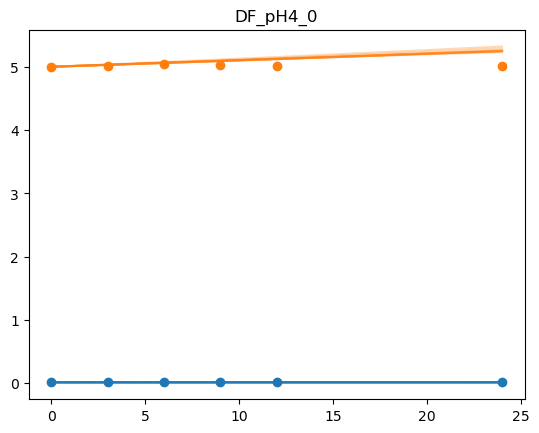

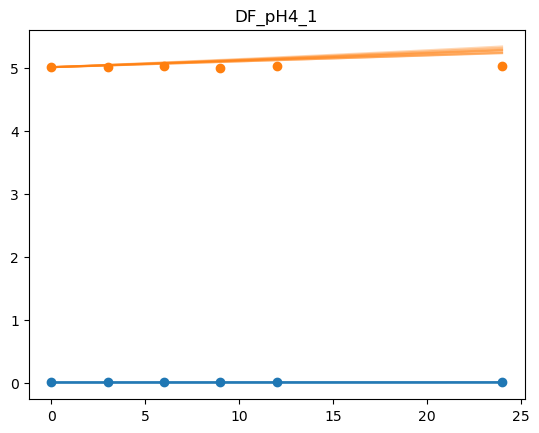

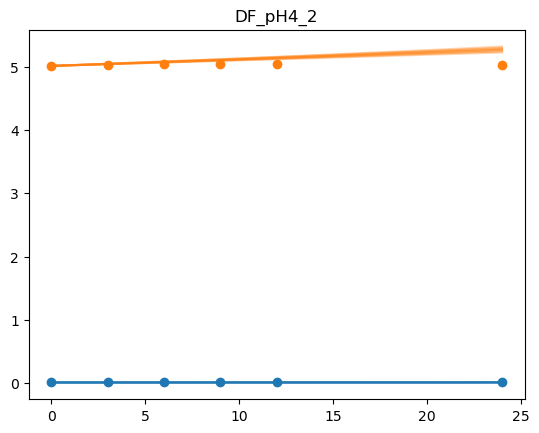

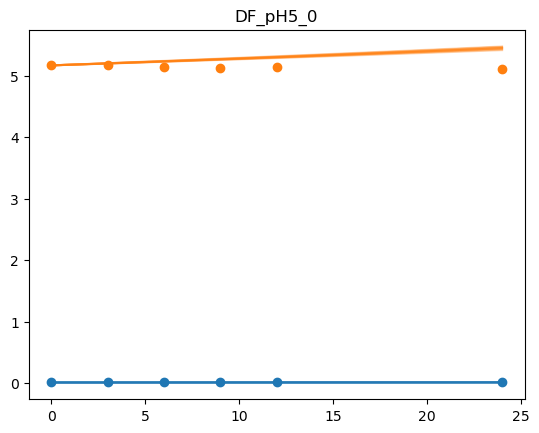

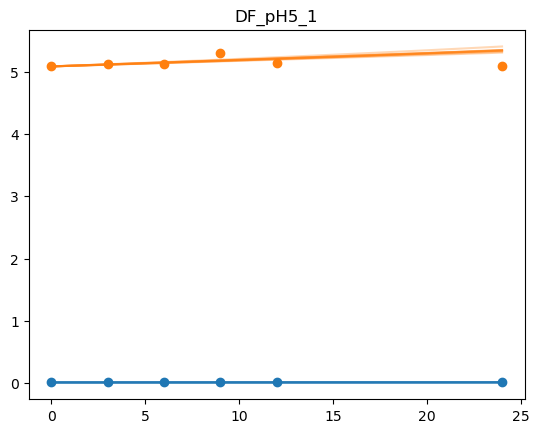

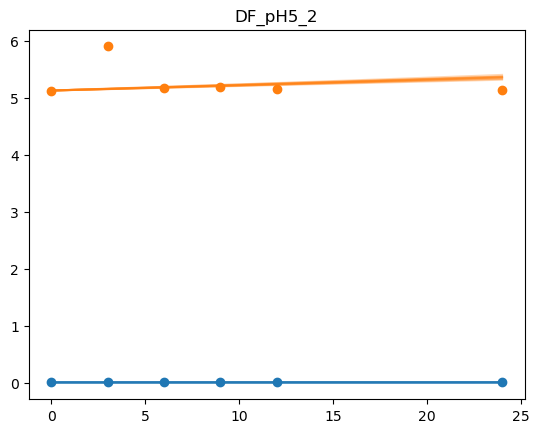

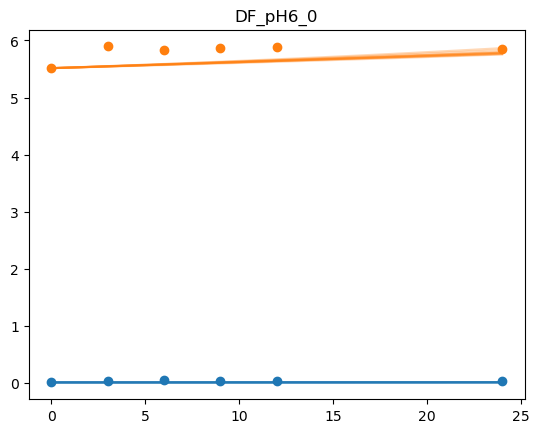

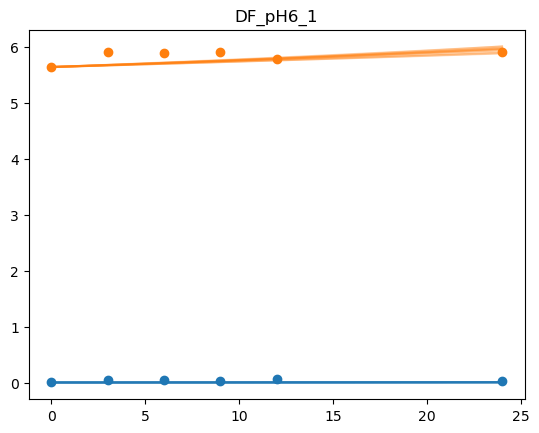

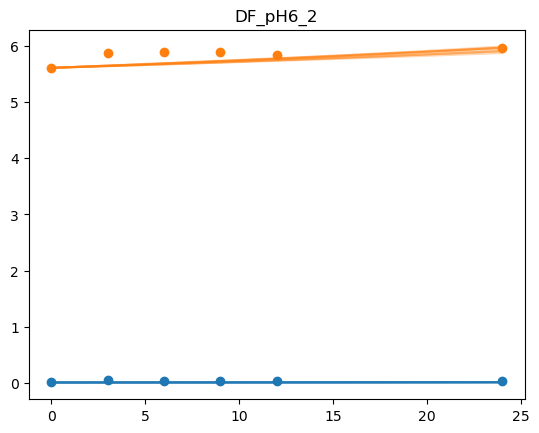

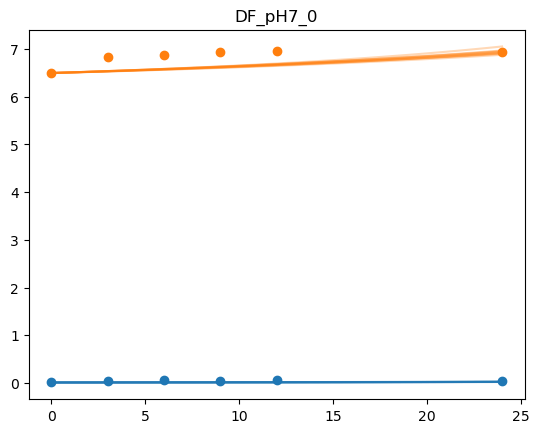

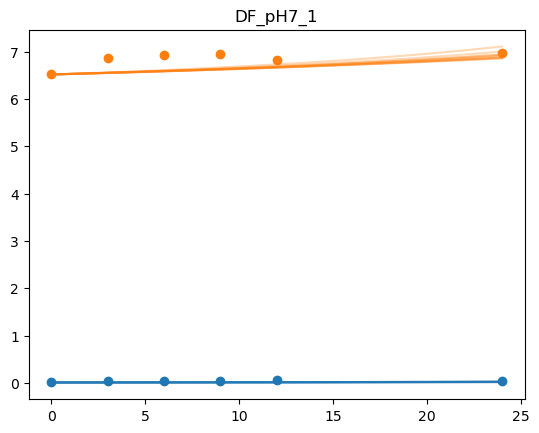

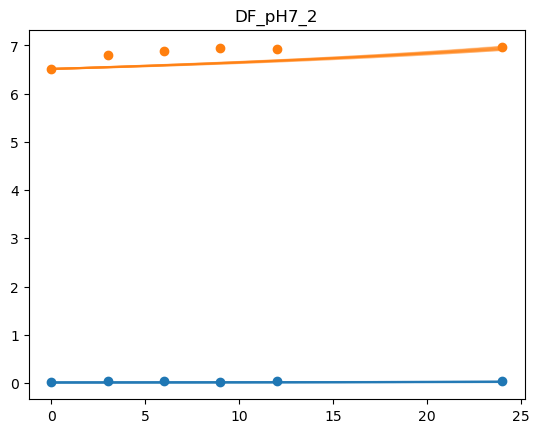

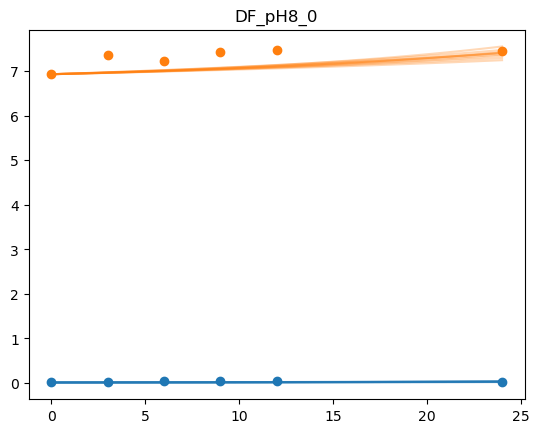

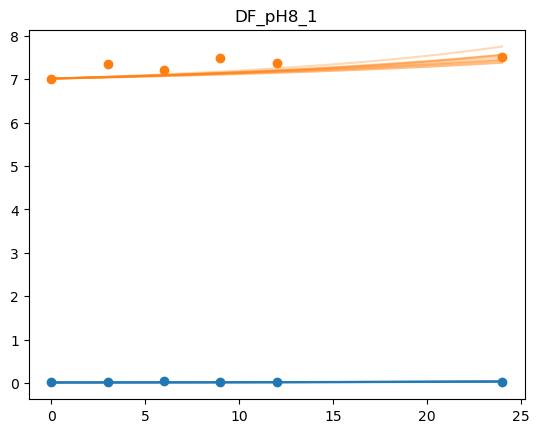

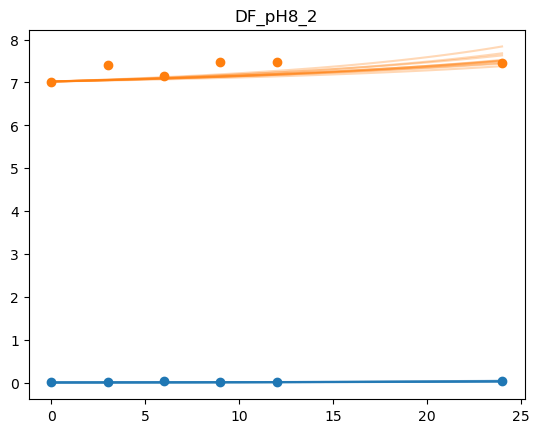

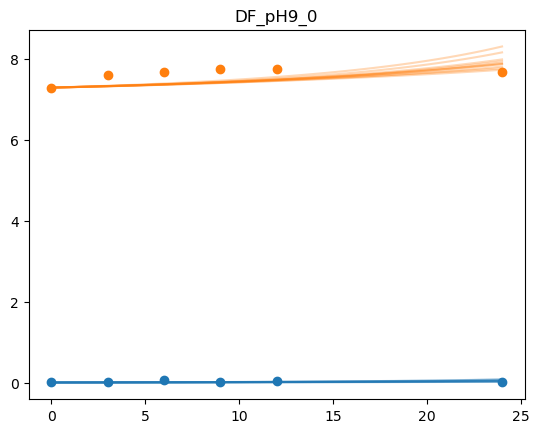

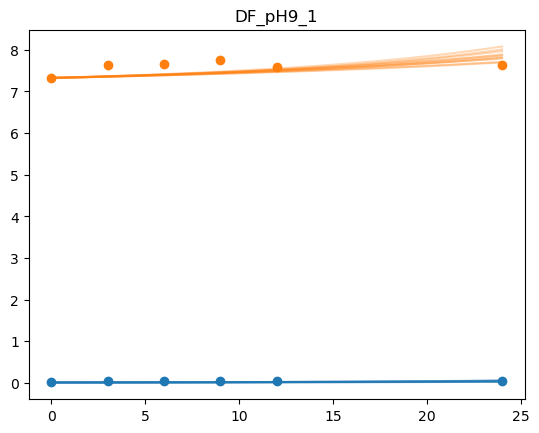

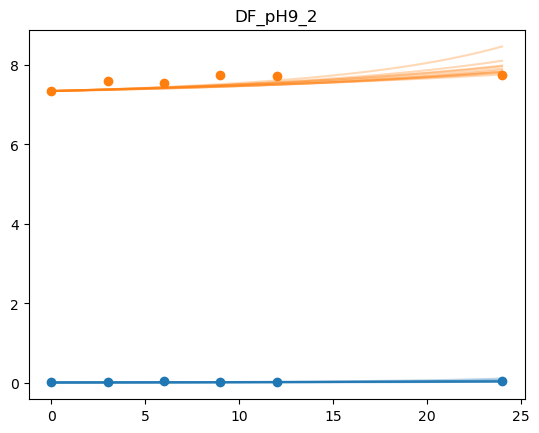

In [20]:
# random conditions to plot
# plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_species.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    # y_preds = ode_model.predict_prior(x0, t_eval, n_sample=10)
    y_preds = ode_model.predict_sample(x0, t_eval, n_sample=10)
    
    # plot 
    for i, s in enumerate(species[:2]):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

In [21]:
#ode_model.estimate_evidence(n_sample=1000, n_trials=3)

In [22]:
ode_model.param_df()

,mean,stdv
0,0.334894,0.029248
1,13.335222,0.141474
2,0.062477,0.002674
3,0.113397,0.481039
4,0.047321,0.012757
5,0.318430,0.035022


In [181]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params.to_csv('Fitting/'+sp+'_param.csv')